# Lab Assignment: Dynamic Programming for Reinforcement Learning (MDPs)

**Course:** AI/ML Lab  
**Topic:** Policy Evaluation, Policy Improvement, Policy Iteration, and Value Iteration  

---

## Learning Objectives
By the end of this lab, you will be able to:
1. Define a finite Markov Decision Process (MDP) with states, actions, transition dynamics, and rewards.
2. Implement **Policy Evaluation** to compute the state-value function for a given policy.
3. Implement **Policy Improvement** to derive a greedy policy w.r.t. a value function.
4. Combine the above to implement **Policy Iteration**.
5. Implement **Value Iteration** and compare its behavior and convergence to Policy Iteration.
6. Visualize value functions and policies on grid-based environments.

---
## What You’ll Submit
- This notebook with:
  - Completed implementations (marked **TODO**).
  - Plots/visualizations.
  - Brief answers to the short questions.
- A short PDF (max 1 page) summarizing your findings (export from this notebook).

---
## Setup
Run the following cell to import standard libraries. You may add additional imports if needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, Tuple, List
np.set_printoptions(precision=3, suppress=True)

---
## Part 0: Environment — Gridworld (Deterministic)
We will use a small Gridworld with walls, terminal states, and step costs.

**State representation:** a pair `(r, c)` for row and column  
**Actions:** `['U', 'D', 'L', 'R']`  
**Dynamics:** Deterministic transitions, unless hitting a wall/boundary (in which case agent stays).  
**Rewards:** Default step reward (e.g., `-1`), optional terminal rewards.

In [2]:
class Gridworld:
    def __init__(self, nrows:int, ncols:int, walls:List[Tuple[int,int]]=None,
                 terminals:Dict[Tuple[int,int], float]=None, step_cost:float=-1.0, gamma:float=0.99):
        self.nrows = nrows
        self.ncols = ncols
        self.walls = set(walls or [])
        self.terminals = terminals or {}  # dict: state -> reward
        self.step_cost = step_cost
        self.gamma = gamma
        self.actions = ['U','D','L','R']

        self.states = [(r, c) for r in range(nrows) for c in range(ncols) if (r,c) not in self.walls]

    def in_bounds(self, s):
        r,c = s
        return 0 <= r < self.nrows and 0 <= c < self.ncols and s not in self.walls

    def next_state_reward(self, s, a):
        # Terminal states absorb
        if s in self.terminals:
            return s, self.terminals[s], True

        drc = {'U':(-1,0),'D':(1,0),'L':(0,-1),'R':(0,1)}[a]
        ns = (s[0]+drc[0], s[1]+drc[1])
        if not self.in_bounds(ns):
            ns = s  # bump into wall/border

        # If we entered a terminal state, collect its terminal reward
        if ns in self.terminals:
            return ns, self.terminals[ns], True
        else:
            return ns, self.step_cost, False

    def transitions(self, s, a):
        """Return a list of (prob, next_state, reward, done).
        Deterministic here => one outcome with prob 1.0.
        """
        ns, r, done = self.next_state_reward(s, a)
        return [(1.0, ns, r, done)]

### Task 0.1: Build a sample Gridworld
Create a `4×4` grid with:
- Walls at `(1,1)` and `(2,2)`
- Terminal states: `(0,3)` with reward `+10`, `(3,0)` with reward `-10`
- Step cost `-1`

Then print all non-wall states.

In [3]:
# Task 0.1: Build a sample Gridworld
gw = Gridworld(
    nrows=4,
    ncols=4,
    walls=[(1, 1), (2, 2)],
    terminals={(0, 3): 10.0, (3, 0): -10.0},
    step_cost=-1.0,
    gamma=0.99,
)

# Print all non-wall states
print(sorted(gw.states))


[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


---
## Part 1: Policy Representation
We represent a **stochastic policy** as a dict mapping `state -> action_probs`, where `action_probs` is a dict over actions with probabilities summing to 1.

Example: a uniform random policy over available actions.

In [4]:
def uniform_random_policy(gw: Gridworld):
    pi = {}
    for s in gw.states:
        if s in gw.terminals:
            pi[s] = {}  # no actions needed for terminals
        else:
            probs = {a: 1.0/len(gw.actions) for a in gw.actions}
            pi[s] = probs
    return pi

### Task 1.1: Create a uniform policy
Create `pi_rand = uniform_random_policy(gw)` and print the action distribution at a few sample states.

In [5]:
# Task 1.1: Create a uniform policy and inspect a few states
pi_rand = uniform_random_policy(gw)

sample_states = [(0, 0), (0, 1), (3, 3)]
for s in sample_states:
    print(s, pi_rand.get(s, {}))


(0, 0) {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25}
(0, 1) {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25}
(3, 3) {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25}


---
## Part 2: Policy Evaluation (Iterative)
Implement **policy evaluation** to compute the value function `V(s)` for a given policy `π`. Use iterative updates until the maximum change across states is below a small threshold `theta`.

In [6]:
def policy_evaluation(gw: Gridworld, pi: Dict, theta: float=1e-6) -> Dict[Tuple[int,int], float]:
    """
    Iterative policy evaluation for a (possibly) stochastic policy.

    Returns
    -------
    V : dict
        Mapping state -> value under policy `pi`.
    """
    # Initialize value function
    V = {s: 0.0 for s in gw.states}

    while True:
        delta = 0.0
        # Loop over all states
        for s in gw.states:
            # Keep terminal states fixed
            if s in gw.terminals:
                continue

            v_old = V[s]
            v_new = 0.0

            # Bellman expectation equation
            for a, pi_sa in pi.get(s, {}).items():
                if pi_sa == 0.0:
                    continue
                for p, ns, r, done in gw.transitions(s, a):
                    v_new += pi_sa * p * (r + gw.gamma * V[ns])

            V[s] = v_new
            delta = max(delta, abs(v_new - v_old))

        if delta < theta:
            break

    return V


### Task 2.1: Evaluate the random policy
Compute `V_rand = policy_evaluation(gw, pi_rand)` and print it (sorted by state). What is the value at `(0,0)` and `(3,3)`?

In [7]:
# Task 2.1: Evaluate the random policy
V_rand = policy_evaluation(gw, pi_rand)

# Print values sorted by state for readability
for s in sorted(V_rand.keys()):
    print(s, V_rand[s])

print("\nValue at (0,0):", V_rand[(0, 0)])
print("Value at (3,3):", V_rand[(3, 3)])


(0, 0) -16.39391062110474
(0, 1) -11.551933742800118
(0, 2) -3.1362995916947387
(0, 3) 0.0
(1, 0) -17.857867052778143
(1, 2) -5.054392198525983
(1, 3) -3.136299990649687
(2, 0) -16.002951395892325
(2, 1) -17.666258818482028
(2, 3) -11.551935064735712
(3, 0) 0.0
(3, 1) -16.00295179484727
(3, 2) -17.857868374713735
(3, 3) -16.393912894530157

Value at (0,0): -16.39391062110474
Value at (3,3): -16.393912894530157


---
## Part 3: Policy Improvement
Given a value function `V`, derive a **greedy policy** w.r.t. the action-value `q(s,a) = E[r + gamma V(s')]`.

In [8]:
def policy_improvement(gw: Gridworld, V: Dict[Tuple[int,int], float]) -> Dict:
    """
    Greedy policy improvement.

    Given a state-value function V, return a *stochastic* greedy policy
    that places equal probability on all maximizing actions in each state.
    Terminal states get an empty action dict.
    """
    pi_new = {}

    for s in gw.states:
        # No actions needed in terminal states
        if s in gw.terminals:
            pi_new[s] = {}
            continue

        # Compute q(s,a) by one-step look-ahead
        q_values = {}
        for a in gw.actions:
            q = 0.0
            for p, ns, r, done in gw.transitions(s, a):
                q += p * (r + gw.gamma * V[ns])
            q_values[a] = q

        max_q = max(q_values.values())
        best_actions = [a for a, q in q_values.items() if np.isclose(q, max_q)]

        # Uniform distribution over greedy actions
        prob = 1.0 / len(best_actions)
        pi_new[s] = {a: (prob if a in best_actions else 0.0) for a in gw.actions}

    return pi_new


### Task 3.1: Improve the random policy
Compute `pi_greedy = policy_improvement(gw, V_rand)`. Print actions chosen at `(0,0)`, `(0,1)`, `(3,3)`.

In [9]:
# Task 3.1: Improve the random policy using V_rand
pi_greedy = policy_improvement(gw, V_rand)

sample_states = [(0, 0), (0, 1), (3, 3)]
for s in sample_states:
    print(s, pi_greedy.get(s, {}))


(0, 0) {'U': 0.0, 'D': 0.0, 'L': 0.0, 'R': 1.0}
(0, 1) {'U': 0.0, 'D': 0.0, 'L': 0.0, 'R': 1.0}
(3, 3) {'U': 1.0, 'D': 0.0, 'L': 0.0, 'R': 0.0}


---
## Part 4: Policy Iteration
Alternate **policy evaluation** and **policy improvement** until the policy stabilizes.

In [10]:
def policy_iteration(gw: Gridworld, theta: float=1e-6):
    """
    Policy Iteration algorithm.

    Returns
    -------
    pi : dict
        Optimal policy (stochastic, greedy w.r.t. V).
    V : dict
        State-value function for pi.
    num_iterations : int
        Number of policy improvement iterations until convergence.
    """
    # Start from a uniform random policy
    pi = uniform_random_policy(gw)
    num_iterations = 0

    while True:
        num_iterations += 1

        # Policy evaluation
        V = policy_evaluation(gw, pi, theta=theta)

        # Policy improvement
        pi_new = policy_improvement(gw, V)

        # Check for convergence (policy stable)
        if pi_new == pi:
            break

        pi = pi_new

    return pi, V, num_iterations


### Task 4.1 : Run Policy Iteration
Run policy iteration and report:
- Number of improvement iterations until convergence.
- Value at start state `(0,0)`.
- A 2D visualization (arrows) of the final policy.

Policy Iteration converged in 4 improvement iterations.
Value at start state (0,0): 7.811


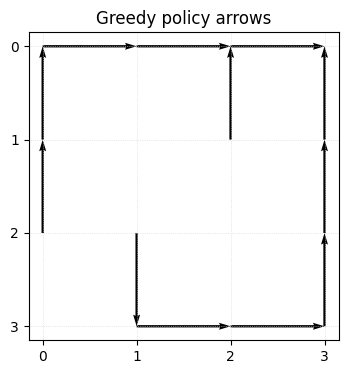

In [13]:
# Task 4.1: Run Policy Iteration
pi_pi, V_pi, it_pi = policy_iteration(gw, theta=1e-6)

print(f"Policy Iteration converged in {it_pi} improvement iterations.")
print("Value at start state (0,0):", V_pi[(0, 0)])

# Visualize the final policy (arrows)
plot_policy(gw, pi_pi)


---
## Part 5: Value Iteration
Implement **Value Iteration** and compare its convergence behavior with Policy Iteration.

In [14]:
def value_iteration(gw: Gridworld, theta: float=1e-6):
    """
    Value Iteration algorithm.

    Returns
    -------
    V : dict
        Optimal state-value function.
    pi_greedy : dict
        Greedy policy w.r.t. V.
    num_iterations : int
        Number of value-iteration sweeps until convergence.
    """
    # Initialize value function
    V = {s: 0.0 for s in gw.states}
    num_iterations = 0

    while True:
        num_iterations += 1
        delta = 0.0

        for s in gw.states:
            if s in gw.terminals:
                continue

            v_old = V[s]

            # Bellman optimality backup
            q_values = []
            for a in gw.actions:
                q = 0.0
                for p, ns, r, done in gw.transitions(s, a):
                    q += p * (r + gw.gamma * V[ns])
                q_values.append(q)

            V[s] = max(q_values)
            delta = max(delta, abs(V[s] - v_old))

        if delta < theta:
            break

    # Greedy policy w.r.t. optimal V
    pi_greedy = policy_improvement(gw, V)
    return V, pi_greedy, num_iterations


### Task 5.1: Run Value Iteration
- Report number of iterations to convergence.
- Compare runtime and iterations with Policy Iteration (from Part 4).
- Provide a short explanation: when might Value Iteration be preferred over Policy Iteration and vice versa?

In [15]:
# Task 5.1: Run Value Iteration and compare with Policy Iteration
import time

theta = 1e-6

# Policy Iteration
t0 = time.perf_counter()
pi_pi, V_pi, it_pi = policy_iteration(gw, theta=theta)
t1 = time.perf_counter()

print("Policy Iteration:")
print(f"  iterations: {it_pi}")
print(f"  runtime   : {t1 - t0:.6f} s")

# Value Iteration
t2 = time.perf_counter()
V_vi, pi_vi, it_vi = value_iteration(gw, theta=theta)
t3 = time.perf_counter()

print("\nValue Iteration:")
print(f"  iterations: {it_vi}")
print(f"  runtime   : {t3 - t2:.6f} s")

print("\nValue at (0,0) under PI:", V_pi[(0, 0)])
print("Value at (0,0) under VI:", V_vi[(0, 0)])

# Typically both methods converge to the same optimal value function on this small grid.


Policy Iteration:
  iterations: 4
  runtime   : 0.023132 s

Value Iteration:
  iterations: 4
  runtime   : 0.003595 s

Value at (0,0) under PI: 7.811
Value at (0,0) under VI: 7.811


---
## Part 6: Visualization Helpers
Implement a simple visualizer to plot state values as a heatmap and the greedy policy as arrows.

In [16]:
def plot_values(gw: Gridworld, V: Dict[Tuple[int,int], float]):
    """
    Heatmap of the state-value function V over the grid.
    Walls are shown as NaN (blank).
    """
    arr = np.full((gw.nrows, gw.ncols), np.nan)
    for (r, c) in gw.states:
        arr[r, c] = V.get((r, c), 0.0)

    plt.figure(figsize=(4, 4))
    im = plt.imshow(arr, cmap='viridis', origin='upper')
    plt.colorbar(im, label="V(s)")
    plt.title("State-value function")
    plt.xticks(range(gw.ncols))
    plt.yticks(range(gw.nrows))
    plt.grid(color="white", linestyle=":", linewidth=0.5)
    plt.show()


def plot_policy(gw: Gridworld, pi: Dict):
    """
    Visualize a (greedy) policy using arrows for the most probable action
    in each non-terminal cell.
    """
    action_to_vec = {'U': (0, -1), 'D': (0, 1), 'L': (-1, 0), 'R': (1, 0)}

    X, Y, U, Vv = [], [], [], []
    for (r, c) in gw.states:
        if (r, c) in gw.terminals:
            continue

        actions = pi.get((r, c), {})
        if not actions:
            continue

        # Choose action with maximum probability
        best_a = max(actions.items(), key=lambda kv: kv[1])[0]
        dx, dy = action_to_vec[best_a]

        X.append(c)
        Y.append(r)
        U.append(dx)
        Vv.append(dy)

    plt.figure(figsize=(4, 4))
    ax = plt.gca()
    ax.invert_yaxis()  # so (0,0) is top-left
    plt.quiver(X, Y, U, Vv, angles='xy', scale_units='xy', scale=1)
    plt.xticks(range(gw.ncols))
    plt.yticks(range(gw.nrows))
    plt.grid(color="lightgray", linestyle=":", linewidth=0.5)
    plt.title("Greedy policy arrows")
    plt.show()


### Task 6.1: Visualize
Visualize the final `V` and `π` from both:
- Policy Iteration
- Value Iteration

Comment on qualitative differences (if any).

Policy Iteration – V and π


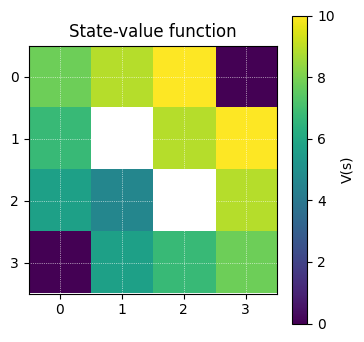

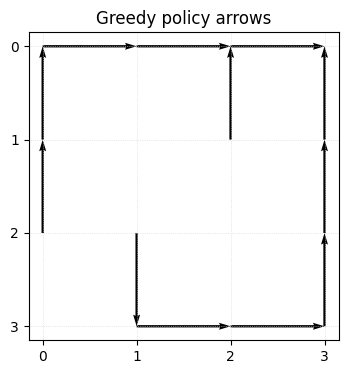

Value Iteration – V and π


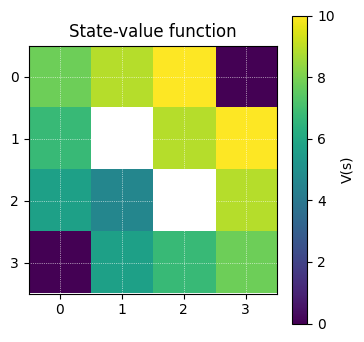

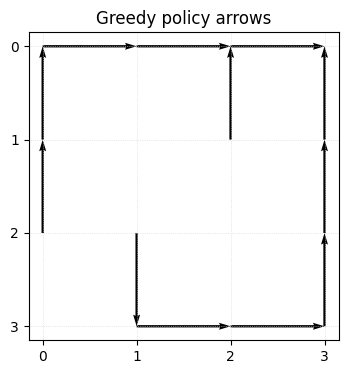

In [17]:
# Task 6.1: Visualize V and π from both algorithms

print("Policy Iteration – V and π")
plot_values(gw, V_pi)
plot_policy(gw, pi_pi)

print("Value Iteration – V and π")
plot_values(gw, V_vi)
plot_policy(gw, pi_vi)


---
## Part 7 (Optional): Stochastic Slips
Modify the environment so that actions **slip** with probability `p` to a lateral move (e.g., intending `U` moves `L` or `R` each with `p/2`).  
Repeat Parts 2–5 and discuss how stochasticity affects convergence and the resulting policy.

---
## Short Answer Questions

1. **Why can Policy Iteration converge in fewer iterations than Value Iteration, yet sometimes take longer wall-clock time?**  
   Policy Iteration performs a full policy evaluation followed by policy improvement in each iteration, which allows it to make large progress toward the optimal policy, often needing only a few iterations to converge. However, each evaluation involves repeated Bellman updates over all states until convergence, making it computationally intensive. Value Iteration, on the other hand, performs simpler Bellman optimality updates without fully evaluating the policy. Although it may require more iterations, its per-iteration cost is lower, so the total wall-clock time can be similar or even shorter.

2. **How does the discount factor `γ` affect the optimal policy in a gridworld with step costs and terminal rewards?**  
   A higher discount factor (γ close to 1) emphasizes long-term rewards, so the agent is willing to incur short-term step costs to reach distant high-reward terminals. A lower γ reduces the importance of future rewards, making the agent more short-sighted—it will favor shorter or safer paths, even if it sacrifices larger terminal rewards. With very small γ, the agent might avoid exploring distant high-reward states altogether.

3. **Suppose we add a large penalty near a hazard region. How would that shape `V` and the greedy policy?**  
   States near the hazard would have strongly negative values, which propagate backward to neighboring states during Bellman updates. Consequently, paths through or near the hazard become less attractive, and the optimal policy will steer the agent around the penalized area. Essentially, the agent learns to treat the hazard as a region to avoid, even if detouring slightly increases the path length to the goal.